# **Group 1 Project - Telemarketing Prediction**

Authors: Hongtianxu Hua, Bongju Yoo, Yonghao Li

Date: 2020-08-20


In [ ]:
!pip install pycaret==2.0
!pip install pandas-profiling
!pip install -U imbalanced-learn

     |████████████████████████████████| 256kB 3.5MB/s 
     |████████████████████████████████| 1.6MB 9.9MB/s 
     |████████████████████████████████| 65.9MB 61kB/s 
     |████████████████████████████████| 12.4MB 22.4MB/s 
     |████████████████████████████████| 266kB 50.9MB/s 
     |████████████████████████████████| 1.2MB 45.2MB/s 
     |████████████████████████████████| 266kB 22.5MB/s 
     |████████████████████████████████| 6.8MB 48.0MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 552kB 53.9MB/s 
     |████████████████████████████████| 1.1MB 28.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 6.0MB 48.6MB/s 
     |████████████████████████████████| 163kB 57.9MB/s 
     |████████████████████████████████| 

In [ ]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
from scipy import interp

from collections import Counter
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

import pandas_profiling as pp
from pycaret.classification import *

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Load dataset
bm = pd.read_csv("https://raw.githubusercontent.com/georgehua/global-historial-crop-yield/master/bank_marketing_scikit_label_dataset.csv")

## 1. **Introduction**

A person’s financial decisions and banking choices depend on multiple variables. In this dataset collected using direct marketing campaigns (phone calls) from a Portuguese banking institution to its clients or potential clients, there are various features for exploration and analysis. Our classification goals include: to predict whether a client will subscribe to a term deposit (variable y); to predict whether a client has credit in default account (variable “default”); and to predict whether a client has any personal loan (variable “loan”).

Our main objective is to analyze this dataset in order to help increase the effectiveness of the bank’s telemarketing campaign.


## 2. **Data Description**

The dataset is composed of 17 attributes: Age of client (age), Type of job (job), Marital status (marital), Level of education (education), Existence of credit (default), Average yearly balance (balance), Housing loan (housing), Personal loan (loan), Communication type (contact), Day of the month (day), Month of the year (month), Last contact duration (duration), Number of contacts made (campaign), Number of days passed since a client was last contacted from a previous campaign (pdays), and Predictor class (y). All features have been converted into corresponding numeric values when we downloaded the dataset. The dataset is publicly available in the UCI Machine learning Repository, which can be retrieved from http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#. All the detailed information about features and description of the one-hot encoding process can be found on https://www.mldata.io/dataset-details/bank_marketing/.

In [ ]:
bm.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30.0,10.0,1.0,0.0,0.0,1787.0,0.0,0.0,0.0,19.0,10.0,79.0,1.0,-1.0,0.0,3.0,0.0
1,33.0,7.0,1.0,1.0,0.0,4789.0,1.0,1.0,0.0,11.0,8.0,220.0,1.0,339.0,4.0,0.0,0.0
2,35.0,4.0,2.0,2.0,0.0,1350.0,1.0,0.0,0.0,16.0,0.0,185.0,1.0,330.0,1.0,0.0,0.0
3,30.0,4.0,1.0,2.0,0.0,1476.0,1.0,1.0,2.0,3.0,6.0,199.0,4.0,-1.0,0.0,3.0,0.0
4,59.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,5.0,8.0,226.0,1.0,-1.0,0.0,3.0,0.0


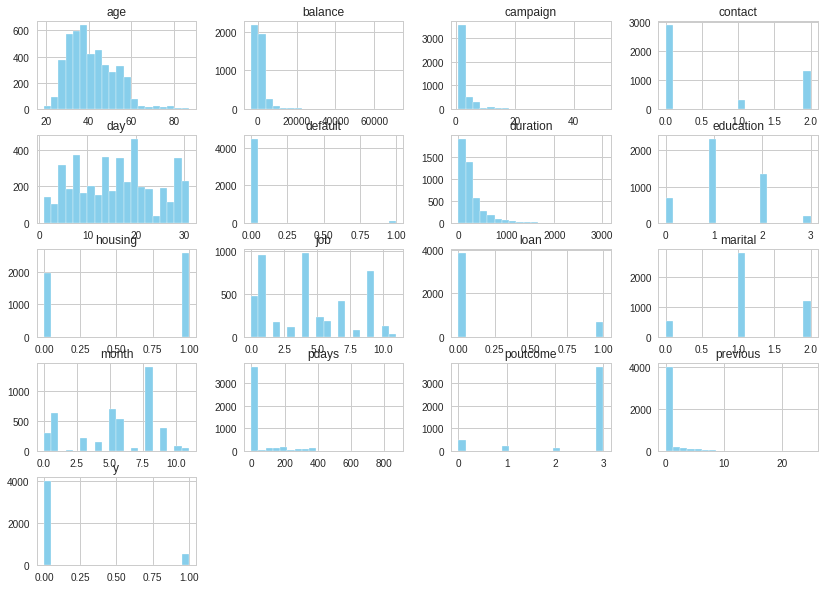

In [ ]:
# Feature plots
plt.style.use('seaborn-whitegrid')
bm.hist(bins=20, figsize=(14, 10), color='skyblue')
plt.show()

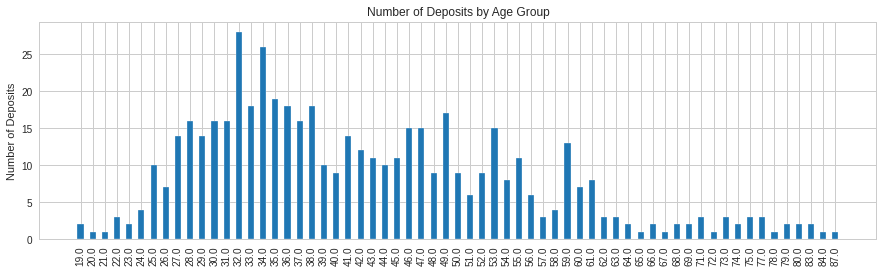

In [ ]:
bm_predict_yes = bm[bm['y'] == 1.0]
bm_predict_no = bm[bm['y'] == 0.0]

sortbyAgeYes = bm_predict_yes.groupby('age').groups
agesYes = []
for x in list(sortbyAgeYes):
    agesYes.append(len(sortbyAgeYes[x]))

# Number of deposits by age group
xAxisNumb = len(sortbyAgeYes)
ind = np.arange(xAxisNumb) 
plt.figure(figsize=(15,4))
plt.bar(ind, agesYes, width=0.5)
plt.ylabel('Number of Deposits')
plt.title('Number of Deposits by Age Group')
labelAges = sortbyAgeYes.keys()
plt.xticks(ind, labelAges, rotation='vertical')
plt.show()

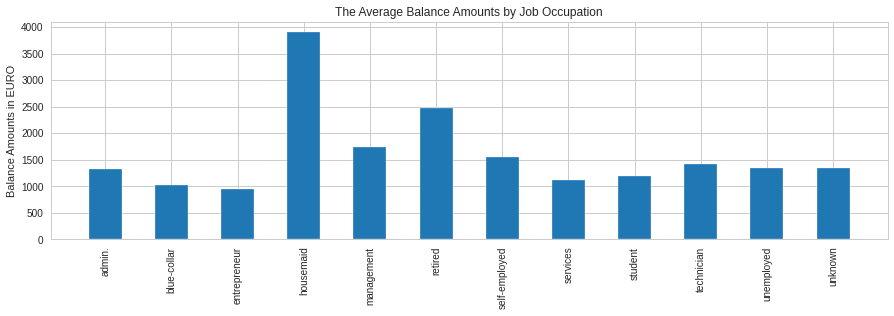

In [ ]:
# The average balance in account by job occupation
groupJob = bm_predict_yes.groupby('job').groups
sumBalance = bm_predict_yes.groupby(['job'])['balance'].sum()
arrNumbBalance = []
for x in list(groupJob):
    arrNumbBalance.append(len(groupJob[x]))

arrAmountBalance = []
for i in range(len(sumBalance)):
    arrAmountBalance.append(sumBalance[i])

arrBalance = []
for i in range(len(sumBalance)):
    arrBalance.append(sumBalance[i])

arrAvgBalance = [x/y for x, y in zip(arrAmountBalance, arrNumbBalance)]
    
xAxisNumb = len(sumBalance)
ind = np.arange(xAxisNumb) 
plt.figure(figsize=(15,4))
plt.bar(ind, arrAvgBalance, width=0.5)
plt.ylabel('Balance Amounts in EURO')
plt.title('The Average Balance Amounts by Job Occupation')
labelAges = ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown']
plt.xticks(ind, labelAges, rotation='vertical')
plt.show()

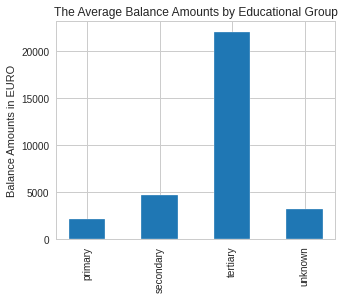

In [ ]:
# The average balance by educational group
groupEdu = bm_predict_yes.groupby('job').groups
arrNumbEdu = []
for x in list(groupEdu):
    arrNumbEdu.append(len(groupEdu[x]))

sumEdu = bm_predict_yes.groupby(['education'])['balance'].sum()
arrAmountEdu = []
for i in range(len(sumEdu)):
    arrAmountEdu.append(sumEdu[i])

arrAvgEdu = [x/y for x, y in zip(arrAmountEdu, arrNumbEdu)]
    
xAxisNumb = len(sumEdu)
ind = np.arange(xAxisNumb) 
plt.figure(figsize=(5,4))
plt.bar(ind, arrAvgEdu, width=0.5)
plt.ylabel('Balance Amounts in EURO')
plt.title('The Average Balance Amounts by Educational Group')
labelAges = ['primary', 'secondary', 'tertiary', 'unknown']
plt.xticks(ind, labelAges, rotation='vertical')
plt.show()

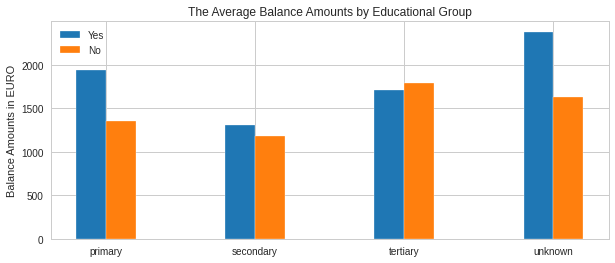

In [ ]:
# The average balance by educational group

# Get average balance  
def getAvgBalanceEdu(pred): 
    groupEdu = pred.groupby('education').groups
    arrNumbEdu = []
    for x in list(groupEdu):
        arrNumbEdu.append(len(groupEdu[x]))

    sumEdu = pred.groupby(['education'])['balance'].sum()
    arrAmountEdu = []
    for i in range(len(sumEdu)):
        arrAmountEdu.append(sumEdu[i])

    arrAvgEdu = [x/y for x, y in zip(arrAmountEdu, arrNumbEdu)]
    arrNumbEdu = []
    arrAmountEdu = []
    return arrAvgEdu

# Bar graph
xAxisNumb = len(sumEdu)
ind = np.arange(xAxisNumb) 
plt.figure(figsize=(10,4))
w = 0.2
plt.bar(ind, getAvgBalanceEdu(bm_predict_yes), width=w)
plt.bar(ind + w, getAvgBalanceEdu(bm_predict_no), width=w)
plt.ylabel('Balance Amounts in EURO')
plt.title('The Average Balance Amounts by Educational Group')
labelAges = ['primary', 'secondary', 'tertiary', 'unknown']
plt.xticks(ind + w/2, labelAges)
plt.legend(labels=['Yes', 'No'])


plt.show()

## 3. **Preprocessing & Exploratory Data Analysis**

Before diving into our analytical and machine learning research questions, we took some time to explore our dataset. Here is a list of important preprocessing steps that we took:

- No Missing Values;
- Change the unit of "duration" from seconds to minutes;
- Drop rows with "duration" < 5s because those interactions do not contribute much to telemarketing;
- Drop rows with "job" or "education" == "unknown";
- Change the target classifier columns to “category” types.


In [ ]:
# Change the unit of "duration" from seconds to minutes
bm['duration'] = bm['duration'].apply(lambda n: n / 60).round(2)

# Drop rows with "duration" < 5s because those interactions do not contribute much
duration_condition = (bm['duration'] < 5 / 60)
bm = bm.drop(bm[duration_condition].index, axis=0, inplace=False)

# Drop rows with "job" or "education" == "unknown"
job_condition = (bm['job'] == 11.0)
bm = bm.drop(bm[job_condition].index, axis=0, inplace=False)
edu_condition = (bm['education'] == 3.0)
bm = bm.drop(bm[edu_condition].index, axis=0, inplace=False)

In [ ]:
# Change the types of the target classifier columns

bm["response"] = bm['y'].astype('category')
bm["response"].describe()
bm = bm.drop('y', axis=1)

bm["credit_default"] = bm['default'].astype('category')
bm["credit_default"].describe()
bm = bm.drop('default', axis=1)

bm["personal_loan"] = bm['loan'].astype('category')
bm["personal_loan"].describe()
bm = bm.drop('loan', axis=1)

In [ ]:
bm["month"].value_counts()

8.0     1336
5.0      675
1.0      611
6.0      491
9.0      375
0.0      286
3.0      212
4.0      134
10.0      72
7.0       46
11.0      45
2.0       18
Name: month, dtype: int64

In [ ]:
# Visualize summary stats and correlations
pp.ProfileReport(bm)

From the above profile report and visualizations, we can clearly see that there is a class imbalance issue within the original dataset. Next we will explore this further.

## 4. **Research Questions**

Part I. Analytical Questions
1. What are the more influential factors when predicting a client’s subscription outcome?
2. Establish the profile of the most responsive customer groups. (Shown in the EDA section)
3. Check for seasonal effects (existence of most responsive months). (Shown in the EDA section)

Part II. Machine Learning Questions
4. Build classification models using “y” as target variable (whether the client has subscribed to a term deposit).
5. Build classification models using “default” as target variable. **(codes in a separate notebook file)**
6. Build classification models using “loan” as target variable. **(codes in a separate notebook file)**
7. Which classification models or ensemble can be best used to question 4. predict whether a client would subscribe to a term deposit (best accuracies)?


**(Note: We applied all techniques and modeling to the three machine learning questions with the same workflow. However, due to the lengthy codes, we've decided to show only codes for the first question starting in the following section, and codes for the other two questions will be submitted as separate notebooks.)**

According to our EDA results and the pandas profiling report, we can answer our 2nd and 3rd analytical questions as such:

- Age group of the most responsive clients is 25 < age < 45;
- Job categories of the most responsive clients are blue-collar, management, and unemployed;
- Most responsive months are April, May, June, July, August, and November (this fact suggests that the company should focus more on the Summer and Fall seasons).

## 5. **Techniques Used** (modeling, resampling, and feature selection)

### 5.1 **Balancing Data**

#### 5.1.1 **Check Imbalance Issue**

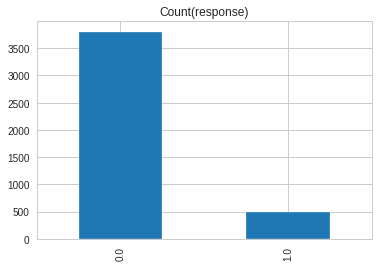

In [ ]:
# Check the imbalance problem in "response"
bm.response.value_counts().plot(kind='bar', title='Count(response)')

From the above bar graph of the "y" or "response" column, the "1" or "yes" class is significantly less than the "0" or "no" class at a ratio of approximately 1:9.

#### 5.1.2 **Testing Stratified Sampling**

To address and try to solve the class imbalance issue, we first test the effectiveness of using stratified sampling alone. The testing algorithm in this case is the Gaussian NB model.

Before the actual testing, we need to set up the different sets of X (predictor sets) and y (target) since our three research questions are targeting different predictors.

In [ ]:
# Set up X and y for the first question
X = bm.drop((['response']), axis=1)
y = bm['response']
X = X.astype('int')
y = y.astype('category')

In [ ]:
# Specify metrics used for performance evaluation
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']

scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV'])

# Set up a 10-fold CV to compare with the stratified approach
cv = KFold(n_splits=10)
scv = StratifiedKFold(n_splits=10)
clf = GaussianNB() # trial run with basic algorithm

In [ ]:
# Trial testing performance comparison for "response" target
for metric in metric_names:
    score1 = cross_val_score(clf, X, y, scoring=metric, cv=cv).mean()
    score2 = cross_val_score(clf, X, y, scoring=metric, cv=scv).mean()
    scores_df.loc[metric] = [score1, score2]

scores_df

,Random-CV,Stratified-CV
f1,0.382771,0.386351
roc_auc,0.809286,0.807362
average_precision,0.351555,0.350992
accuracy,0.837717,0.837716
precision,0.341861,0.344575
recall,0.438774,0.441347


As we can see from the above results, although this is only a testing NB classifier, most of the F1, precision, and recall scores are extremely low due to the class imbalance problem.

Notice that the accuracy can seem very high even with just a basic tester model because of the highly unbalance nature of the dataset. For example, since the "response" column has a 1:9 ratio between two classes, even a 100% "no" blind classification would still have an accuracy of around 90%.

Even after we implemented stratified sampling, the imbalance issue is still severely affecting the performance metrics (with little to no improvement or even decrease in performance). At this point, it becomes critical for us to find ways to balance the binary classes for each research question.

#### 5.1.3 **Resampling**

After extensive research, we decided to use resampling methods to counter-act the imbalance in our dataset. Resampling is a widely recognized and implemented technique for dealing with highly unbalanced datasets such as fraud detection or facial recognition. Fundamentally, resampling includes the following two ways of sampling:

1. Undersampling: only sampling a small amount of observations from the majority class in order to minimize the difference in amount between the majority and the minority class;
2. Oversampling: either copying or synthesizing data points that belong to the minority/under-represented class so that its amount can be similar to that of the majority class.

Since our dataset only has about 4000 observations, undersampling would lead to a major loss of information and we would have only a very small chunk of data to work with.

However, some oversampling techniques are more prone to introducing overfitting into the dataset. For example, the most basic and naive strategy of oversampling is the Random Over Sampling method, which functions by randomly duplicating existing samples until the amount of majority and minority classees are equal.

To control for the possibility of overfitting, we take the following steps:

1. We are not using the Random Over Sampler method;
2. We ensure the validity of the oversampling process by implementing stratified 10-fold cross validation during each model evaluation;
3. Instead of only looking at accuracy, we are also checking other metrics such as F1, AUC, precision, and recall scores.

This way we can get more meaningful results from our dataset.

In addition to scikit-learn, we will also be using the Python library imbalanced-learn which is compatible with scikit-learn and is part of scikit-learn-contrib projects.


##### 5.1.3.1 **Setting Up Before Oversampling**

Here we set up the stratified 10-fold CV and a list of models (not yet tuned) that we will use for testing the effectiveness of several oversampling methods.

In [ ]:
RANSTA = 50

scv = StratifiedKFold(n_splits=10, random_state=RANSTA, shuffle=True)

models = []
models.append((LogisticRegression(solver='lbfgs', max_iter=7000)))
models.append((KNeighborsClassifier(n_neighbors=5)))
models.append((DecisionTreeClassifier()))
models.append((RandomForestClassifier()))
models.append((GaussianNB()))
models.append((SVC()))

To make the oversampling method testing process more succinct and easy to read, we first create a helper function using for loops to evaluate the list of models and print out the metrics table. 

In [ ]:
def oversampleReport(models, metric_names, X_resampled, y_resampled):
  """
  Print model and metrics report table
  """
  scores_cols = ['LR', 'KNN', 'DT', 'RF', 'NB', 'SVC']
  scores = pd.DataFrame(index=metric_names, columns=scores_cols)

  for key, model in enumerate(models):
      for metric in metric_names:
          score = cross_val_score(model, X_resampled, y_resampled, scoring=metric, cv=scv).mean()
          scores.at[metric, scores_cols[key]] = score 
  
  return scores

##### 5.1.3.2 **Oversampling Only (SMOTE and ADASYN)**

To perform oversampling, we start by using one of the most known techniques: SMOTE (Synthetic Minority Over-sampling Technique). This method create synthetic datapoints in the following steps:

1. For each real/existing data point, seek for its K nearest neighbors (default K = 5)
2. Randomly choose one of the neighbors and build a vector between the two points
3. Multiplying the vector with a random number between one and zero to get the new data point.

The Adaptive Synthetic (ADASYN) is an adaptive approach of SMOTE.

SMOTE: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106

ADASYN: https://www.researchgate.net/publication/224330873_ADASYN_Adaptive_Synthetic_Sampling_Approach_for_Imbalanced_Learning

##### **SMOTE**

In [ ]:
# SMOTE oversampling for the first question
smote = SMOTE(random_state=RANSTA)
X_resampled_s1, y_resampled_s1 = smote.fit_resample(X, y)

# Check the number of observations in each class after resampling
print(sorted(Counter(y_resampled_s1).items()))

oversampleReport(models, metric_names, X_resampled_s1, y_resampled_s1)

[(0.0, 3803), (1.0, 3803)]


,LR,KNN,DT,RF,NB,SVC
f1,0.855145,0.845146,0.885778,0.928486,0.794455,0.504118
roc_auc,0.918126,0.905572,0.881932,0.980662,0.867242,0.62695
average_precision,0.894122,0.865935,0.833388,0.978691,0.841094,0.618768
accuracy,0.853275,0.831711,0.88154,0.925323,0.759932,0.568634
precision,0.844151,0.78323,0.869918,0.914583,0.694734,0.592367
recall,0.866685,0.917958,0.895077,0.942939,0.92769,0.439121


##### **ADASYN**

In [ ]:
# ADASYN oversampling for the first question
ada = ADASYN(random_state=RANSTA)
X_resampled_a1, y_resampled_a1 = ada.fit_resample(X, y)

# Check the number of observations in each class after resampling
print(sorted(Counter(y_resampled_a1).items()))

oversampleReport(models, metric_names, X_resampled_a1, y_resampled_a1)

[(0.0, 3803), (1.0, 3760)]


,LR,KNN,DT,RF,NB,SVC
f1,0.849048,0.83503,0.881194,0.927511,0.789457,0.480433
roc_auc,0.915679,0.899661,0.88357,0.981492,0.867891,0.611678
average_precision,0.889896,0.855351,0.83021,0.980309,0.842721,0.601281
accuracy,0.848474,0.819247,0.879809,0.927408,0.755258,0.556658
precision,0.840975,0.764927,0.869149,0.913724,0.689867,0.575991
recall,0.857447,0.919681,0.891489,0.944681,0.922872,0.412234


##### 5.1.3.3 **Combination of Over- and Undersampling (SMOTETomek and SMOTEENN)**

In addition to using oversampling by itself, we also decided to test the combination methods which consist of both oversampling and undersampling techniques. Since SMOTE generates samples without regards to the underlying distribution, it might create some noisy samples where the two classes have no clear distinction. In this case, implementing undersampling algorithms such as Tomek's link and Edited Nearest Neighbors can be good for cleaning noisy samples.

Tomek's link: https://dl.acm.org/doi/10.1145/1007730.1007735

ENN: https://pdfs.semanticscholar.org/c1a9/5197e15fa99f55cd0cb2ee14d2f02699a919.pdf

The imbalanced-learn library has implemented these two algorithms in combination with SMOTE to create two useful classes: SMOTETomek and SMOTEENN.

##### **SMOTETomek**

In [ ]:
# SMOTETomek combo for the first question
smo_tmk = SMOTETomek(random_state=RANSTA)
X_resampled_st1, y_resampled_st1 = smo_tmk.fit_resample(X, y)

# Check the number of observations in each class after resampling
print(sorted(Counter(y_resampled_st1).items()))

oversampleReport(models, metric_names, X_resampled_st1, y_resampled_st1)

[(0.0, 3678), (1.0, 3678)]


##### **SMOTEENN**

In [ ]:
# SMOTE-ENN combo for the first question
smo_enn = SMOTEENN(random_state=RANSTA)
X_resampled_se1, y_resampled_se1 = smo_enn.fit_resample(X, y)

# Check the number of observations in each class after resampling
print(sorted(Counter(y_resampled_se1).items()))

oversampleReport(models, metric_names, X_resampled_se1, y_resampled_se1)

[(0.0, 2180), (1.0, 3044)]


,LR,KNN,DT,RF,NB,SVC
f1,0.904723,0.965724,0.923638,0.952533,0.859778,0.700816
roc_auc,0.945166,0.989878,0.905882,0.987742,0.896995,0.678393
average_precision,0.950599,0.987347,0.8913,0.990052,0.899628,0.732697
accuracy,0.887452,0.959032,0.912137,0.943341,0.819685,0.649111
precision,0.89317,0.943181,0.910678,0.937182,0.786571,0.696014
recall,0.916893,0.989487,0.937252,0.967473,0.948422,0.706293


##### SMOTEENN Wins

From the above results, we can clearly see that the combination of SMOTE (oversampling) and ENN (undersampling/cleaning) works best for all three research questions with different target variables. After resampling using SMOTEENN, the metrics for each algorithm have significantly increased compared to those before resampling.

After stratified CV and resampling, the resampled dataset can now be used for feature selection, further modeling, hyperparameter tuning, and model evaluation.

### 5.2 **Feature Selection Using RFECV**

In [ ]:
# train-test 80/20 split for "response" classification
X_train, X_test, y_train, y_test = train_test_split(X_resampled_se1, y_resampled_se1, test_size=0.2, random_state=RANSTA)

#### Plotting out the feature importance (answering anaytical question 1)

Optimal number of features : 15
Best features : ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'personal_loan']


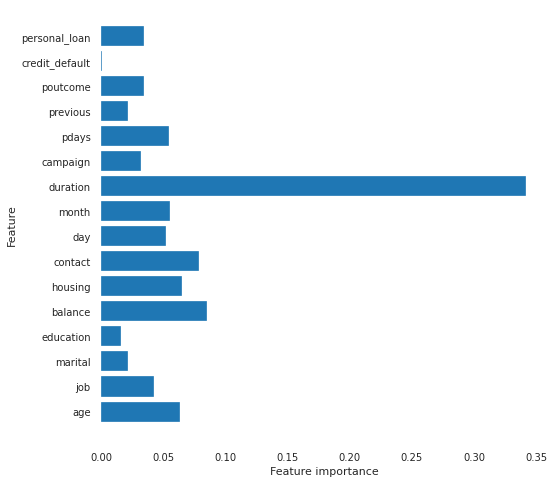

In [ ]:
cv_estimator = RandomForestClassifier(n_jobs=4, random_state =RANSTA)
cv_estimator.fit(X_train, y_train)
cv_selector = RFECV(cv_estimator,cv= 10, step=1,scoring='accuracy')
cv_selector = cv_selector.fit(X_train, y_train)
rfecv_mask = cv_selector.get_support()

rfecv_features = []

for bool, feature in zip(rfecv_mask, X_train.columns):
    if bool:
        rfecv_features.append(feature)

print('Optimal number of features :', cv_selector.n_features_)
print('Best features :', rfecv_features)
n_features = X_train.shape[1]
plt.figure(figsize=(8,8))
plt.barh(range(n_features), cv_estimator.feature_importances_, align='center') 
plt.yticks(np.arange(n_features), X_train.columns.values) 
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

From the RFECV feature selection plot above, we can answer the last analytical question regarding most influential factor. When using term deposit response (Yes/No) as the classification target, the msot influential factor is "duration".

In [ ]:
# Apply feature selection to do train-test split again
X_resampled_se1 = X_resampled_se1.loc[: , ['age', 'job', 'marital', 'education', 'balance', 'housing', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'personal_loan']]
X_train, X_test, y_train, y_test = train_test_split(X_resampled_se1, y_resampled_se1, test_size=0.2, random_state=RANSTA)

## 6. **Further Modeling and Hyperparameter Tuning**

To apply hyperparameter tuning and check if we can further improve our models, we select KNN, Logistic Regression, and Random Forest to do some more testing.

Here we create a helper function which we will use to streamline the process of hyperparameter tuning using GridSearchCV and return the best parameters for each model.

In [ ]:
def hyperTuning(model, param_grid, X_train, y_train, X_test, y_test):
  """
  @params model: ML model, scikit-learn object
  @params param_grid: the hyperparameter for the model
  @return best hyper params (cross-validated)
  """
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10, scoring='accuracy',error_score=0)
  grid_result = grid_search.fit(X_train, y_train)
  # summarize results
  
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

  print("-----------------------------------------------------------")
  print()
  print("Best Accuracy: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  print()

  y_true, y_pred = y_test, grid_result.predict(X_test)
  print("Detailed classification report:")
  print()
  print(classification_report(y_true, y_pred))

  return grid_result.best_params_

Before actually using GridSearchCV to tune the hyperparameters of the classifiers, we want to look at **ROC curves** since there are roughly equal numbers of observations for each class after the resampling process.

The area under the **ROC curve (AUC)** is a measure of how well a parameter can distinguish between two diagnostic groups, which makes it perfect for analyzing binary classification ("0" or "1" in our case) -- An area of 1 represents a perfect test.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


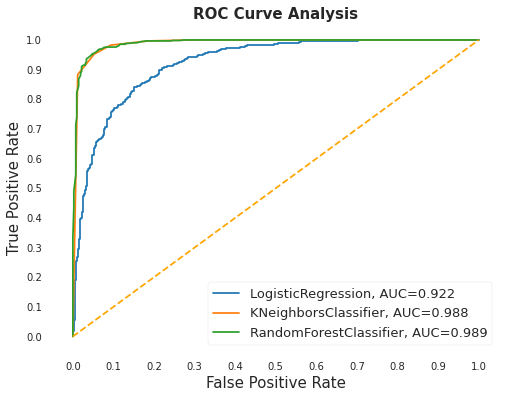

In [ ]:
classifiers = [LogisticRegression(random_state=RANSTA), 
               KNeighborsClassifier(), 
               RandomForestClassifier(random_state=RANSTA)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

We also want to use **Hyperparameter Tuning with GridSearchCV** to get the best parameters for each of the following models.


### 6.1. **KNN**

In [ ]:
# GridSearchCV
best_knn = hyperTuning(KNeighborsClassifier(), 
            dict(leaf_size=list(range(1,50)), n_neighbors=list(range(1,30)), p=[1,2]),
            X_train, y_train, X_test, y_test)

0.983008 (0.006468) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 1}
0.984924 (0.004795) with: {'leaf_size': 1, 'n_neighbors': 1, 'p': 2}
0.980377 (0.007923) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 1}
0.981095 (0.008251) with: {'leaf_size': 1, 'n_neighbors': 2, 'p': 2}
0.968174 (0.010594) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 1}
0.963869 (0.011930) with: {'leaf_size': 1, 'n_neighbors': 3, 'p': 2}
0.962669 (0.011590) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 1}
0.956929 (0.012101) with: {'leaf_size': 1, 'n_neighbors': 4, 'p': 2}
0.946398 (0.013073) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 1}
0.939698 (0.012562) with: {'leaf_size': 1, 'n_neighbors': 5, 'p': 2}
0.944722 (0.010459) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 1}
0.937544 (0.013850) with: {'leaf_size': 1, 'n_neighbors': 6, 'p': 2}
0.930842 (0.012649) with: {'leaf_size': 1, 'n_neighbors': 7, 'p': 1}
0.920553 (0.015022) with: {'leaf_size': 1, 'n_neighbors': 7, 'p': 2}
0.926775 (0.012264) with: {'leaf_s

After hyperparameter tuning, we’ve found that the best parameters for the K Nearest Neighbors classifier’s 'leaf_size', 'n_neighbors', and ‘p’ are '1', ‘1’, and ‘2’ with the accuracy of 0.984. All other metrics are almost perfect.

(Note: "Best hyperparamters" might change at each runtime, due to cross-validation.)

### 6.2 **Logistic Regression**

In [ ]:
best_lr = hyperTuning(LogisticRegression(), 
            dict(C = np.logspace(-4, 4, 20), max_iter = [1000, 2500, 5000]),
            X_train, y_train, X_test, y_test)

0.830590 (0.017765) with: {'C': 0.0001, 'max_iter': 1000}
0.830590 (0.017765) with: {'C': 0.0001, 'max_iter': 2500}
0.830590 (0.017765) with: {'C': 0.0001, 'max_iter': 5000}
0.829873 (0.017457) with: {'C': 0.00026366508987303583, 'max_iter': 1000}
0.829873 (0.017457) with: {'C': 0.00026366508987303583, 'max_iter': 2500}
0.829873 (0.017457) with: {'C': 0.00026366508987303583, 'max_iter': 5000}
0.833941 (0.017355) with: {'C': 0.0006951927961775605, 'max_iter': 1000}
0.833941 (0.017355) with: {'C': 0.0006951927961775605, 'max_iter': 2500}
0.833941 (0.017355) with: {'C': 0.0006951927961775605, 'max_iter': 5000}
0.844946 (0.017225) with: {'C': 0.0018329807108324356, 'max_iter': 1000}
0.844946 (0.017225) with: {'C': 0.0018329807108324356, 'max_iter': 2500}
0.844946 (0.017225) with: {'C': 0.0018329807108324356, 'max_iter': 5000}
0.857392 (0.018360) with: {'C': 0.004832930238571752, 'max_iter': 1000}
0.857392 (0.018360) with: {'C': 0.004832930238571752, 'max_iter': 2500}
0.857392 (0.018360) wi

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


After hyperparameter tuning, we’ve found that the best parameters for the Logistic Regression classifier’s 'C' and 'max_iter' are '4.281' and ‘2500’ with the accuracy of 0.885. Other metrics range from 0.87 to 0.92.

(Note: "Best hyperparamters" might change at each runtime, due to cross-validation.)

### 6.3 **Random Forest**

In [ ]:
best_rf = hyperTuning(RandomForestClassifier(), dict(n_estimators = [10, 100, 1000], max_features = ['sqrt', 'log2']),
            X_train, y_train, X_test, y_test)

0.928214 (0.013141) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.938026 (0.011234) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.939702 (0.012637) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.928931 (0.010037) with: {'max_features': 'log2', 'n_estimators': 10}
0.940419 (0.009701) with: {'max_features': 'log2', 'n_estimators': 100}
0.938983 (0.012840) with: {'max_features': 'log2', 'n_estimators': 1000}
-----------------------------------------------------------

Best Accuracy: 0.940419 using {'max_features': 'log2', 'n_estimators': 100}

Detailed classification report:

              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94       420
         1.0       0.95      0.97      0.96       625

    accuracy                           0.95      1045
   macro avg       0.95      0.95      0.95      1045
weighted avg       0.95      0.95      0.95      1045



After hyperparameter tuning, we’ve found that the best parameters for the Random Forest classifier’s 'max_features' and 'n_estimators' are 'sqrt' and ‘1000’ with the accuracy of 0.941. All other metrics are above 0.90. 

(Note: "Best hyperparamters" might change at each runtime, due to cross-validation.)

After GridSearchCV tuning, here are the ROC curves with the best hyperparameters:

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


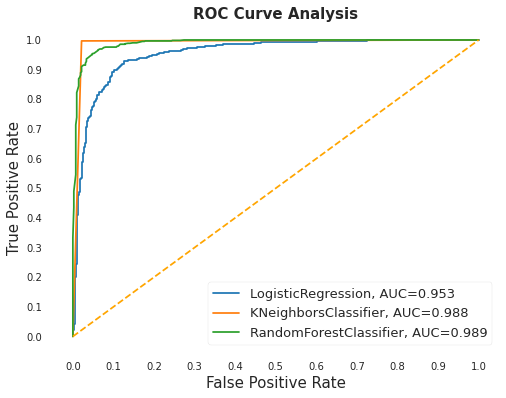

In [ ]:
classifiers = [LogisticRegression(C = best_lr['C'], max_iter = best_lr['max_iter'], random_state=RANSTA), 
               KNeighborsClassifier(leaf_size = best_knn['leaf_size'], n_neighbors = best_knn['n_neighbors'], p = best_knn['p']), 
               RandomForestClassifier(max_features = best_rf['max_features'], n_estimators = best_rf['n_estimators'], random_state=RANSTA)]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test, yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

##### Random Forest Wins (For Now...)

Compared to the previous ROC curve analysis, the resulting AUC scores for the LR and RF classifiers have improved slightly. Particularly, the AUC of Logistic Regression model has grown 0.032 and the curve has become closer to (0,1), which means after hyperparameter tuning the performance of the LR model has improved the most among the three compared classifiers.

#### Conclusions and Suggestions

From our analysis, we can conclude that the bank should consider targeting the following client profile when conducting telemarketing campaign:

- Aged between 25 and 45 and;
- Working as blue-collar, management, or unemployed.

We also suggest that the bank should focus more of its energy on the Summer and Fall seasons because the target group is more likely to say "Yes" during those months. However, more data collected from different years should be analyzed to check if this seasonal effect is consistent across time.

After stratified sampling and resampling, we populated the imbalanced dataset so the classification algorithms would work better with higher accuracy. We've looked at several algorithms, but the Random Forest and KNN seem to outperform the others. The bank should consider using our models with the suggested parameters to predict the likelihood of a client submitting a term deposit, while informing future telemarketing decisions.

Based on the results of the ROC curve analysis, the best classifier with the highest AUC score is RF, followed by KNN. But, the RF’s score is just 0.001 higher than the KNN’s. Meanwhile, the KNN’s F1 score is 0.04 higher than the RF’s, which is also not a huge difference between these two classifiers. Consequently, other factors should be used to determine the best model between the classifiers. In the 7. Discussion section, we will discuss further about the potential factors that may help us to choose the best classifier model. 



## 7. **Discussion**

In section 6.1, the GridSearchCV renders the hyperparaemter of K = 1, for our KNN model. We believe this is the behavior of either overfitting or the resampling method perfectly sperate the two predicting classes. To dig out the reason behind the unnormal K value, we tried to use PCA to visualize the distribution of two predicting classes.

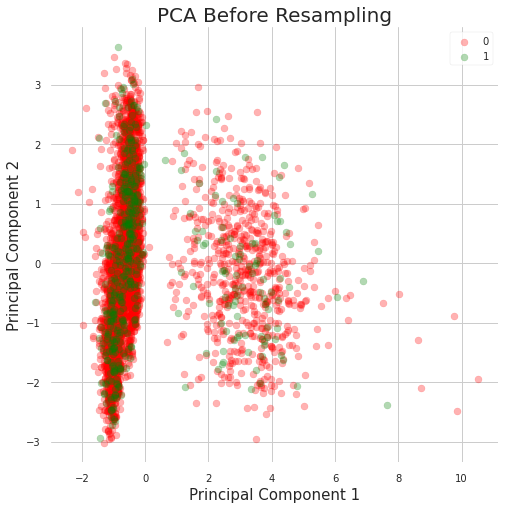

In [ ]:
bm_x_pca = StandardScaler().fit_transform(bm.drop(['response'], axis=1))
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(bm_x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
final_pca_df = pd.concat([principalDf, bm[["response"]]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA Before Resampling', fontsize = 20)


targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = final_pca_df['response'] == target
    ax.scatter(final_pca_df.loc[indicesToKeep, 'principal component 1']
               , final_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

In [ ]:
pca.explained_variance_ratio_

array([0.15896604, 0.10772808])

Together, the first two principal components contain around 26% of the information in the dataset.

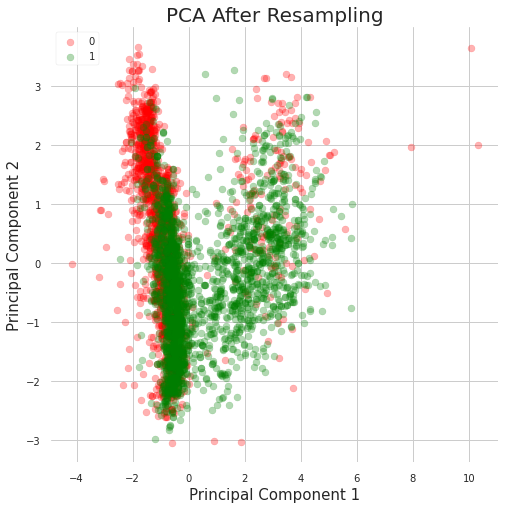

In [ ]:
train_df = pd.concat([X_train, y_train], axis = 1)
train_df.reset_index(drop=True, inplace=True)
X_train_pca = StandardScaler().fit_transform(train_df.drop(['response'], axis=1))

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
final_pca_df = pd.concat([principalDf, train_df[["response"]]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA After Resampling', fontsize = 20)


targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = final_pca_df['response'] == target
    ax.scatter(final_pca_df.loc[indicesToKeep, 'principal component 1']
               , final_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

In [ ]:
pca.explained_variance_ratio_

array([0.17372207, 0.11289552])

Together, the two principal components for after-resampling dataset contain around 28% of the information in the dataset.

From the PCA plots, we can find resampling indeed created more true values for our predicting variables, but this process also makes it harder to differentiate the two classes.

We obtained a group of better models, for KNN, LR & RF after resampling, but this process may lead to overfitting the dataset, the examination on a new fresh dataset is necessary to validate our models.

## 8. **Self assessment**

**Bongju Yoo**


1.   Hyperparameter Tuning (part)
2.   Modeling (part)
3.   EDA (part)
4.   Data description (part)
5.   Formulate the report (part)
6.   Clean up codes (part)

**Hongtianxu Hua**


1.   Hyperparameter Tuning (part)
2.   Modeling (part)
3.   Discussion
4.   Data description
5.   Formulate the report (part)
6.   Clean up codes (part)


**Yonghao Li**

1.  Preprocessing & EDA
2.  Check Imbalance Issue
3.  Stratified Sampling and Resampling (Oversampling and Combo)
4.  RFECV Feature Selection
5.  kNN Hyperparameter Tuning (Part)
6.  ROC Curve Analysis
7.  Formulate the report (Part)
8.  PyCaret (Excluded in Final Version)

## 9. **Appendix**

## Citation

Bank Marketing Data Set: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

Bank Marketing Data Set Description and Encoding: https://www.mldata.io/dataset-details/bank_marketing/

PCA using Python (scikit-learn): https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

PyCaret: https://towardsdatascience.com/announcing-pycaret-2-0-39c11014540e

Imbalanced-learn Python Library: https://imbalanced-learn.org/stable/install.html

RFECV Feature Selection: https://medium.com/analytics-vidhya/feature-selection-using-scikit-learn-5b4362e0c19b

KNN Hyperparameter Tuning: https://medium.com/datadriveninvestor/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f

GridSearchCV Hyperparameter Tuning: https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

